In [78]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from joblib import dump, load
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.lines as mlines
from imblearn.metrics import specificity_score

# Train Test Data

In [2]:
boosting_models = pd.read_csv("../Data/rf_xgb_ada.csv")

In [6]:
es_train = pd.read_csv("../Data/Energy_Star_Train.csv",encoding='utf-8')
es_test = pd.read_csv("../Data/Energy_Star_Test.csv",encoding='utf-8')

In [7]:
tco_train = pd.read_csv("../Data/TCO_Train.csv")
tco_test = pd.read_csv("../Data/TCO_Test.csv")

In [8]:
# Enery Star 

# X
es_x_train = es_train.drop(columns = 'ENERGY_STAR')
es_y_train = es_train['ENERGY_STAR']

# Y
es_x_test = es_test.drop(columns = 'ENERGY_STAR')
es_y_test = es_test['ENERGY_STAR']

# TCO 

# X
tco_x_train = tco_train.drop(columns = 'TCO')
tco_y_train = tco_train['TCO']

# Y 
tco_x_test = tco_test.drop(columns = 'TCO')
tco_y_test = tco_test['TCO']

## SMOTE

In [38]:
es_y_train.value_counts()

0    69915
1    39810
Name: ENERGY_STAR, dtype: int64

In [32]:
# Energy Star
sm = SMOTE(random_state = 42)
es_x_train_sm, es_y_train_sm = sm.fit_resample(es_x_train,es_y_train)  

In [36]:
es_y_train_sm.value_counts()

1    69915
0    69915
Name: ENERGY_STAR, dtype: int64

In [42]:
tco_y_train.value_counts()

0    109652
1        73
Name: TCO, dtype: int64

In [41]:
# TCO 
tco_x_train_sm, tco_y_train_sm = sm.fit_resample(tco_x_train,tco_y_train) 

In [43]:
tco_y_train_sm.value_counts()

1    109652
0    109652
Name: TCO, dtype: int64

# Energy Star

## 1.1 Logistic Regression

In [44]:
logit_param_grid = {
    'penalty': ['l2'], 
    'C': [0.0001, 0.01, 0.1, 1, 10],     
    'solver': ['lbfgs', 'sag', 'saga']}

logit = LogisticRegression(class_weight = 'balanced', max_iter = 1000)

grid = GridSearchCV(logit, logit_param_grid, scoring = 'accuracy', cv = 3, n_jobs=-1)

grid.fit(es_x_train, es_y_train)

/home/sofia/Homework/venv/sofi_project/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'sag', 'saga']},
             scoring='accuracy')

In [46]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=10, class_weight='balanced', max_iter=1000, solver='saga')


In [9]:
#logit = LogisticRegression(class_weight = 'balanced', solver='saga', penalty='l2', C = 10, max_iter=10000)
#logit.fit(es_x_train,es_y_train)
es_logit_y_pred =   logit.predict(es_x_test)
es_logit_y_pred_prob = logit.predict_proba(es_x_test)[:,1]
accuracy_score(es_y_test, es_logit_y_pred)

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.852

In [15]:
# SAVE
dump(logit,'../Data/es_logit_model_weights.pkl')

['../Data/es_logit_model_weights.pkl']

In [4]:
# Load saved model
logit = load('../Data/es_logit_model_weights.pkl') 

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


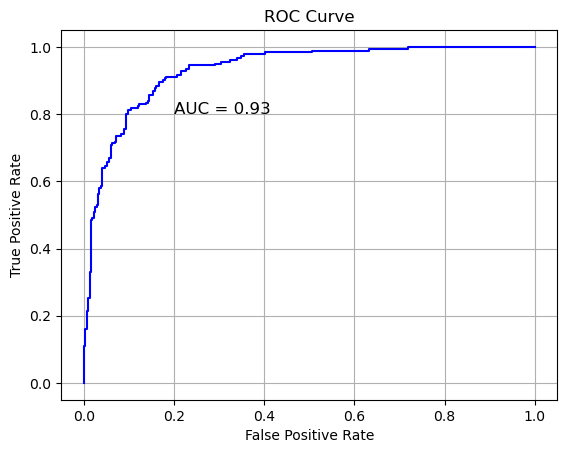

In [10]:
# ROC 
# Roc - 3 curves
es_logit_fpr, es_logit_tpr, es_logit_thresholds = roc_curve(es_y_test, es_logit_y_pred_prob)
es_logit_auc = roc_auc_score(es_y_test, es_logit_y_pred_prob)
plt.plot(es_logit_fpr, es_logit_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {es_logit_auc:.2f}', fontsize=12)
plt.show()

In [110]:
precision = precision_score(es_y_test, es_logit_y_pred)
recall = recall_score(es_y_test, es_logit_y_pred)
f1 = f1_score(es_y_test, es_logit_y_pred)
accuracy = accuracy_score(es_y_test, es_logit_y_pred)
specificity = specificity_score(es_y_test, es_logit_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 0.7584541062801933
Recall: 0.8674033149171271
F1-Score: 0.8092783505154638
Accuracy: 0.852
Specificity: 0.8432601880877743


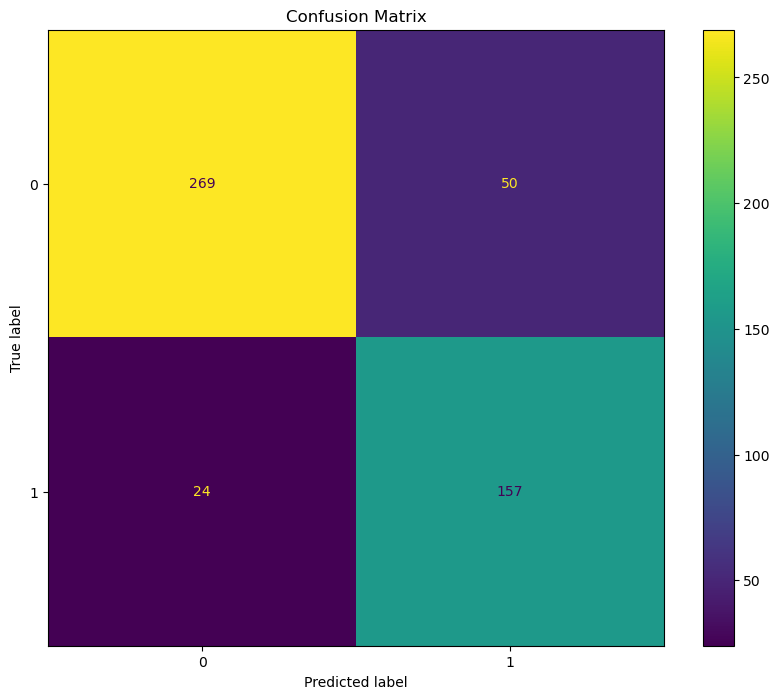

In [111]:
# Confusion Matrix
cm = confusion_matrix(es_y_test, es_logit_y_pred, labels=logit.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logit.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

## 1.2 SVM

In [ ]:
svm_param_grid = {'C': [0.01, 0.1, 1, 10], 'gamma': [1,0.1,0.01],'kernel': ['linear','rbf', 'sigmoid']}

svm_grid = GridSearchCV(SVC(class_weight = 'balanced'), svm_param_grid, scoring = 'accuracy', cv = 3, n_jobs=-1)

svm_grid.fit(es_x_train,es_y_train)

In [ ]:
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)

In [14]:
#es_svm = SVC(class_weight = 'balanced')
#es_svm.fit(es_x_train,es_y_train)
es_svm_y_pred =   es_svm.predict(es_x_test)
es_svm_y_pred_prob = es_svm.decision_function(es_x_test)
accuracy_score(es_y_test, es_svm_y_pred)

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.902

In [13]:
# SAVE
dump(es_svm,'../Data/es_svm_model_weights.pkl')

# Load saved model
es_svm = load('../Data/es_svm_model_weights.pkl') 

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


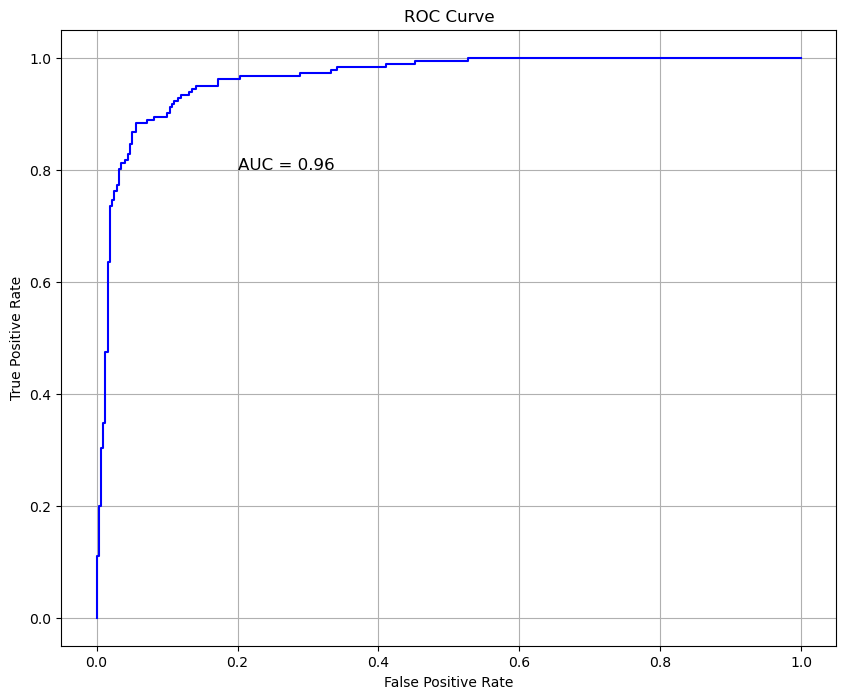

In [15]:
# ROC 
es_svm_fpr, es_svm_tpr, es_svm_thresholds = roc_curve(es_y_test, es_svm_y_pred_prob)
es_svm_auc = roc_auc_score(es_y_test, es_svm_y_pred_prob)
plt.plot(es_svm_fpr, es_svm_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {es_svm_auc:.2f}', fontsize=12)
plt.show()

In [112]:
precision = precision_score(es_y_test, es_svm_y_pred)
recall = recall_score(es_y_test, es_svm_y_pred)
f1 = f1_score(es_y_test, es_svm_y_pred)
accuracy = accuracy_score(es_y_test, es_svm_y_pred)
specificity = specificity_score(es_y_test, es_svm_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 0.83
Recall: 0.9171270718232044
F1-Score: 0.8713910761154855
Accuracy: 0.902
Specificity: 0.8934169278996865


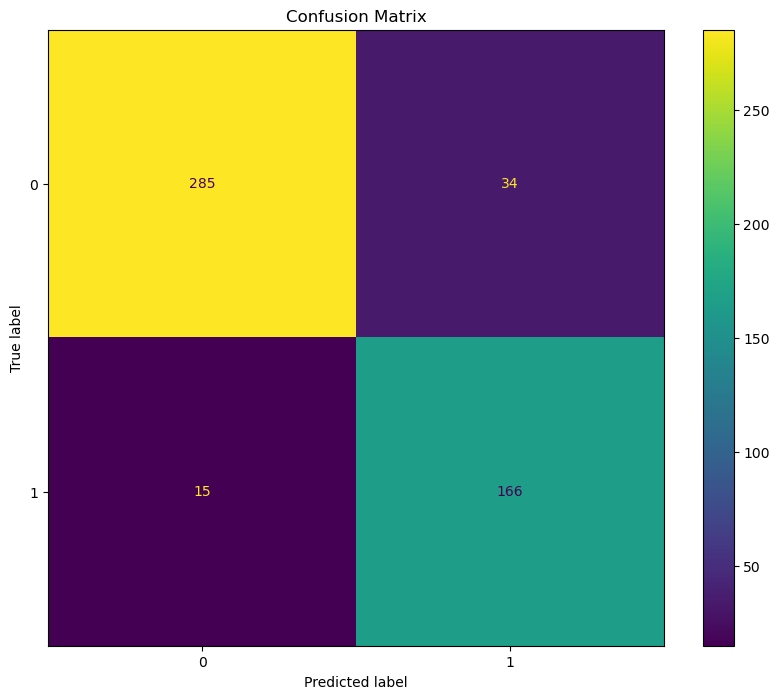

In [17]:
# Confusion Matrix
cm = confusion_matrix(es_y_test, es_svm_y_pred, labels=es_svm.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=es_svm.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

## 1.3 KNN

In [21]:
#es_knn = KNeighborsClassifier(n_neighbors=50)
#es_knn.fit(es_x_train,es_y_train)
es_knn_y_pred =   es_knn.predict(es_x_test)
es_knn_y_pred_prob = es_knn.predict_proba(es_x_test)[:,1]
accuracy_score(es_y_test, es_knn_y_pred)

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.912

In [19]:
# SAVE
dump(es_knn,'es_knn_model_weights.pkl')

# Load saved model
es_knn = load('../Data/es_knn_model_weights.pkl') 

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


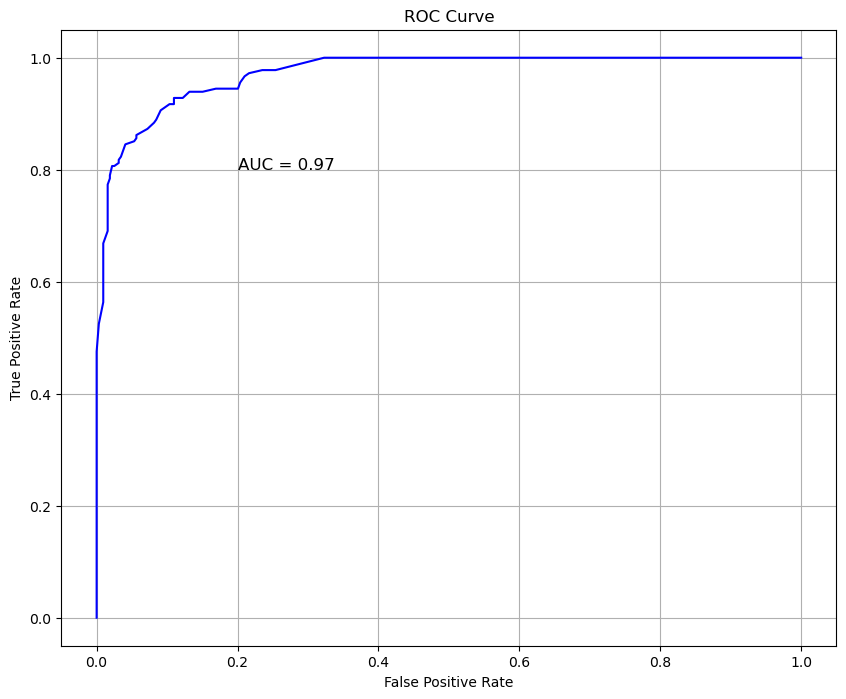

In [22]:
# ROC 
es_knn_fpr, es_knn_tpr, es_knn_thresholds = roc_curve(es_y_test, es_knn_y_pred_prob)
es_knn_auc = roc_auc_score(es_y_test, es_knn_y_pred_prob)
plt.plot(es_knn_fpr, es_knn_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {es_knn_auc:.2f}', fontsize=12)
plt.show()

In [113]:
precision = precision_score(es_y_test, es_knn_y_pred)
recall = recall_score(es_y_test, es_knn_y_pred)
f1 = f1_score(es_y_test, es_knn_y_pred)
accuracy = accuracy_score(es_y_test, es_knn_y_pred)
specificity = specificity_score(es_y_test, es_knn_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 0.9005847953216374
Recall: 0.850828729281768
F1-Score: 0.875
Accuracy: 0.912
Specificity: 0.9467084639498433


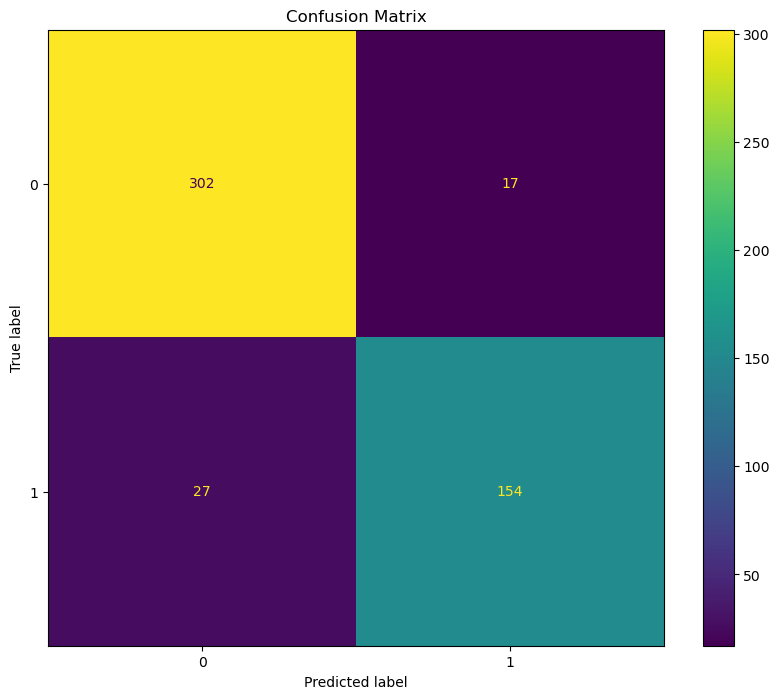

In [114]:
# Confusion Matrix
cm = confusion_matrix(es_y_test, es_knn_y_pred, labels=es_knn.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=es_knn.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve All Models

In [32]:
# Bagging and Boosting Models
# ROC
es_rf_fpr, es_rf_tpr, es_rf_thresholds = roc_curve(es_y_test, boosting_models['es_rf_y_pred_prob'])
es_xgb_fpr, es_xgb_tpr, es_xgb_thresholds = roc_curve(es_y_test, boosting_models['es_xgb_y_pred_prob'])
es_ada_fpr, es_ada_tpr, es_ada_thresholds = roc_curve(es_y_test, boosting_models['es_ada_y_pred_prob'])

# AUC 
es_rf_auc = roc_auc_score(es_y_test, boosting_models['es_rf_y_pred_prob'])
es_xgb_auc = roc_auc_score(es_y_test, boosting_models['es_xgb_y_pred_prob'])
es_ada_auc = roc_auc_score(es_y_test, boosting_models['es_ada_y_pred_prob'])

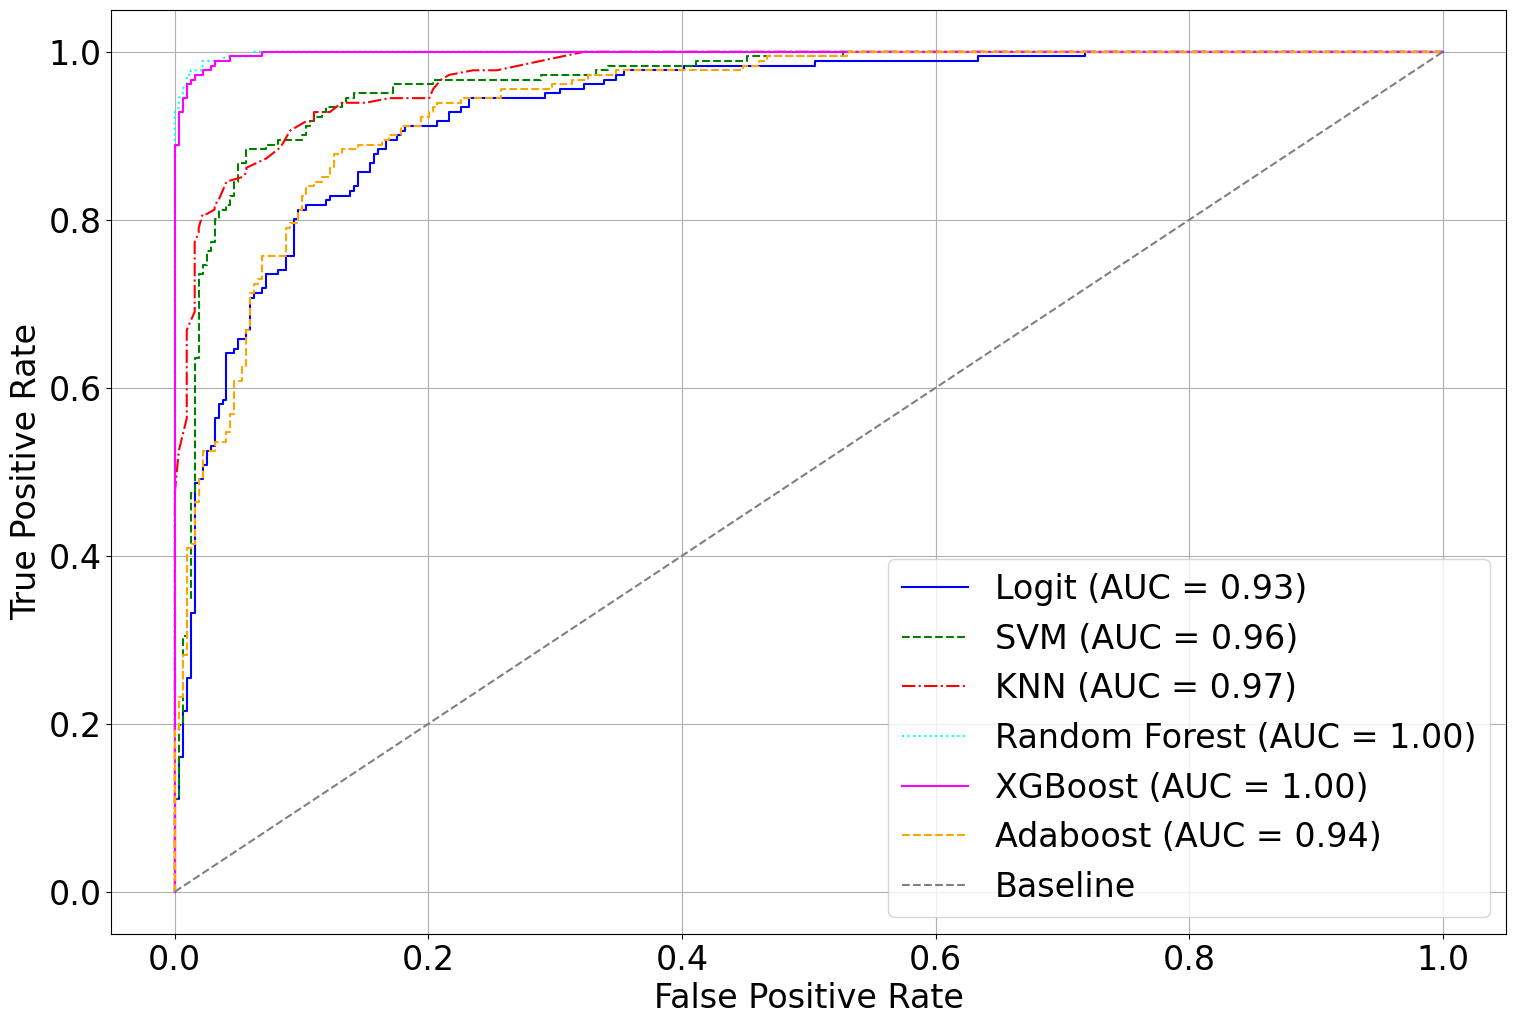

In [106]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']
line_styles = ['-', '--', '-.', ':', '-', '--']
models = ['Logit', 'SVM', 'KNN', 'Random Forest', 'XGBoost', 'Adaboost']
fpr_tpr_auc = [(es_logit_fpr, es_logit_tpr, es_logit_auc), 
               (es_svm_fpr, es_svm_tpr, es_svm_auc), 
               (es_knn_fpr, es_knn_tpr, es_knn_auc), 
               (es_rf_fpr, es_rf_tpr, es_rf_auc), 
               (es_xgb_fpr, es_xgb_tpr, es_xgb_auc), 
               (es_ada_fpr, es_ada_tpr, es_ada_auc)]

plt.figure(figsize=(18, 12))

for i, (fpr, tpr, auc) in enumerate(fpr_tpr_auc):
    plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[i], 
             label=f'{models[i]} (AUC = {auc:.2f})')

baseline = plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')[0]

plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)

plt.legend(loc='lower right', fontsize='x-large', title_fontsize='20', frameon=True,prop={'size': 24})

plt.show()


# TCO

## 1.1 Logistic Regression

In [45]:
#tco_logit = LogisticRegression(class_weight = 'balanced', solver='saga', penalty='l2', C = 10, max_iter=10000)
#tco_logit.fit(tco_x_train,tco_y_train)
tco_logit_y_pred =   tco_logit.predict(tco_x_test)
tco_logit_y_pred_prob = tco_logit.predict_proba(tco_x_test)[:,1]
accuracy_score(tco_y_test, tco_logit_y_pred)

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.956

In [75]:
logit_param_grid = {
    'penalty': ['l2','None'], 
    'C': [0.0001, 0.01, 0.1, 1, 10],     
    'solver': ['lbfgs', 'sag', 'saga']}

logit = LogisticRegression(class_weight = 'balanced', max_iter = 10000)

grid = GridSearchCV(logit, logit_param_grid, scoring = 'accuracy', cv = 3, n_jobs=-1)

grid.fit(tco_x_train, tco_y_train)

/home/sofia/Homework/venv/sofi_project/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.86298473 0.86299385 0.60265208        nan        nan        nan
 0.95985418 0.59946229 0.73260424        nan        nan        nan
 0.98112554 0.94525404 0.83489633        nan        nan        nan
 0.99085897 0.89151971 0.91867851        nan        nan        nan
 0.99697425 0.9344452  0.97079973        nan        nan        nan]
  category=UserWarning


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.01, 0.1, 1, 10],
                         'penalty': ['l2', 'None'],
                         'solver': ['lbfgs', 'sag', 'saga']},
             scoring='accuracy')

In [76]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=10, class_weight='balanced', max_iter=10000)


In [ ]:
tco_logit_grid_search = LogisticRegression(class_weight = 'balanced', solver='lbfgs', penalty='l2', C = 10, max_iter=10000)
tco_logit_grid_search.fit(tco_x_train,tco_y_train)
tco_logit_y_pred_grid_search =   tco_logit_grid_search.predict(tco_x_test)
tco_logit_y_pred_prob_grid_search = tco_logit_grid_search.predict_proba(tco_x_test)[:,1]
accuracy_score(tco_y_test, tco_logit_y_pred_grid_search)

In [43]:
# SAVE
#dump(tco_logit,'tco_logit_model_weights.pkl')

# Load saved model
tco_logit = load('../Data/tco_logit_model_weights.pkl') 

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


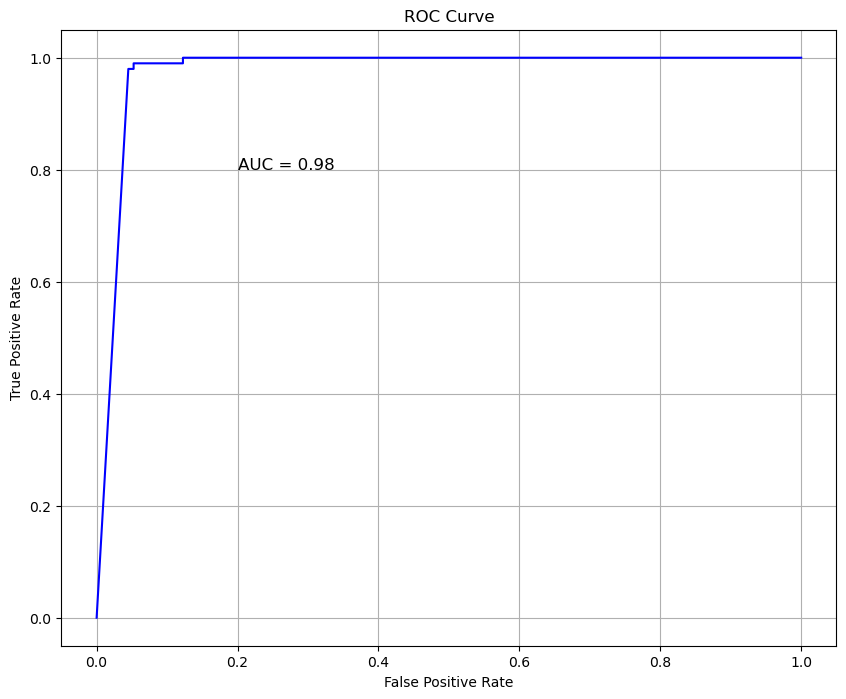

In [46]:
# ROC 
tco_logit_fpr, tco_logit_tpr, tco_logit_thresholds = roc_curve(tco_y_test, tco_logit_y_pred_prob)
tco_logit_auc = roc_auc_score(tco_y_test, tco_logit_y_pred_prob)
plt.plot(tco_logit_fpr, tco_logit_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {tco_logit_auc:.2f}', fontsize=12)
plt.show()

In [116]:
precision = precision_score(tco_y_test, tco_logit_y_pred)
recall = recall_score(tco_y_test, tco_logit_y_pred)
f1 = f1_score(tco_y_test, tco_logit_y_pred)
accuracy = accuracy_score(tco_y_test, tco_logit_y_pred)
specificity = specificity_score(tco_y_test, tco_logit_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 0.8305084745762712
Recall: 0.98
F1-Score: 0.8990825688073395
Accuracy: 0.956
Specificity: 0.95


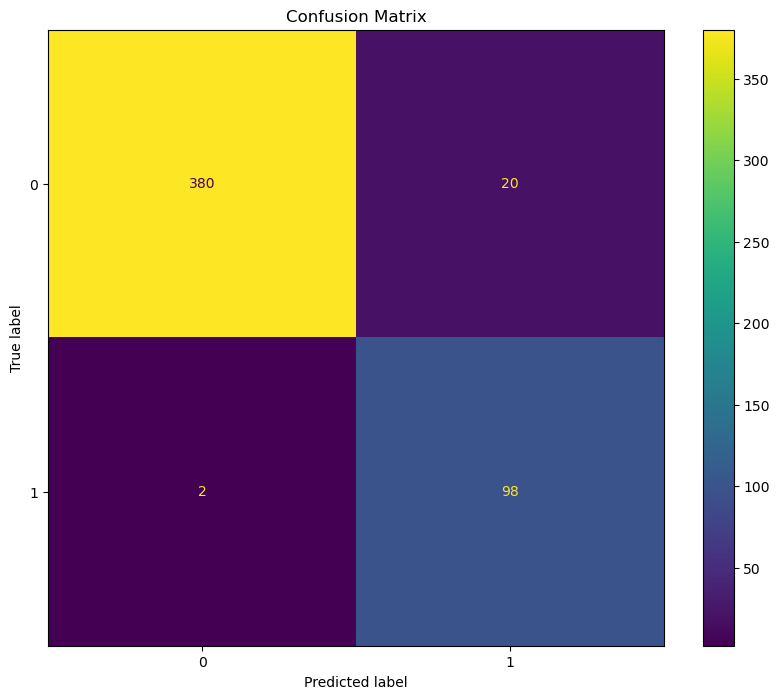

In [48]:
# Confusion Matrix
cm = confusion_matrix(tco_y_test, tco_logit_y_pred, labels=tco_logit.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tco_logit.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

# 1.2 SVM

In [50]:
#tco_svm = SVC(class_weight = 'balanced')
#tco_svm.fit(tco_x_train,tco_y_train)
tco_svm_y_pred =   tco_svm.predict(tco_x_test)
tco_svm_y_pred_prob = tco_svm.decision_function(tco_x_test)
accuracy_score(tco_y_test, tco_svm_y_pred)

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.978

In [49]:
# SAVE
#dump(tco_svm,'tco_svm_model_weights.pkl')

# Load saved model
tco_svm = load('../Data/tco_svm_model_weights.pkl') 

/Users/sofialaval/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


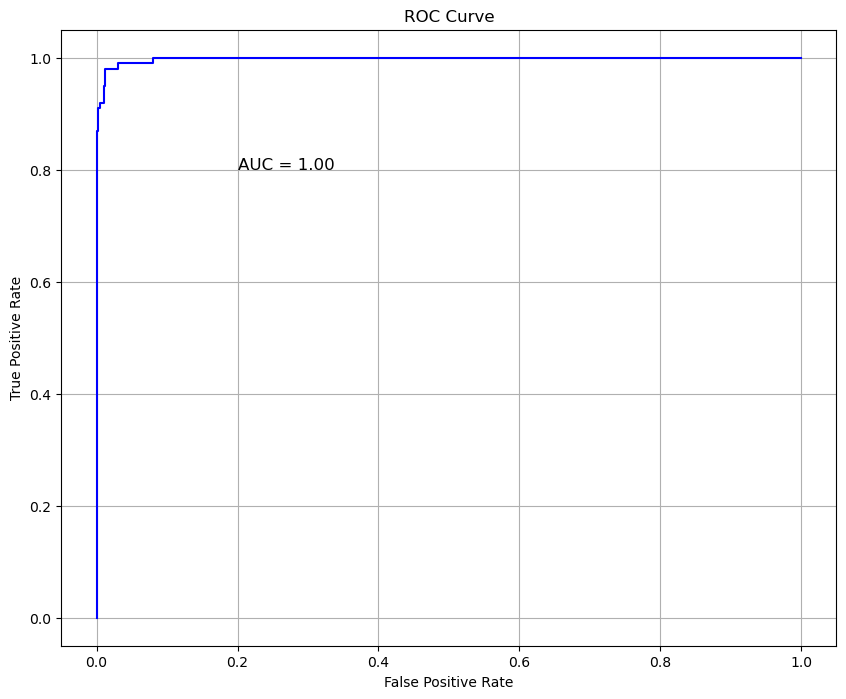

In [51]:
# ROC 
tco_svm_fpr, tco_svm_tpr, tco_svm_thresholds = roc_curve(tco_y_test, tco_svm_y_pred_prob)
tco_svm_auc = roc_auc_score(tco_y_test, tco_svm_y_pred_prob)
plt.plot(tco_svm_fpr, tco_svm_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {tco_svm_auc:.2f}', fontsize=12)
plt.show()

In [115]:
precision = precision_score(tco_y_test, tco_svm_y_pred)
recall = recall_score(tco_y_test, tco_svm_y_pred)
f1 = f1_score(tco_y_test, tco_svm_y_pred)
accuracy = accuracy_score(tco_y_test, tco_svm_y_pred)
specificity = specificity_score(tco_y_test, tco_svm_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 0.978494623655914
Recall: 0.91
F1-Score: 0.9430051813471503
Accuracy: 0.978
Specificity: 0.995


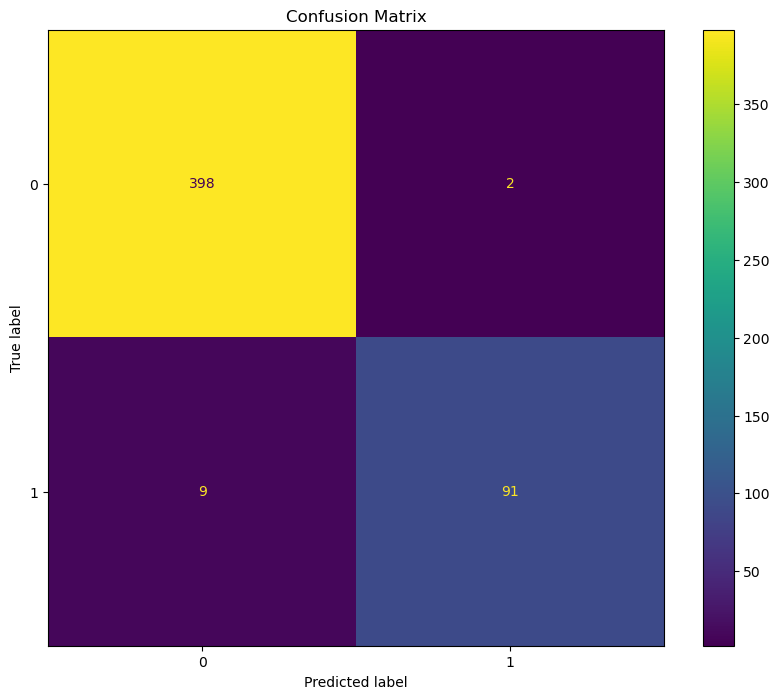

In [107]:
# Confusion Matrix
cm = confusion_matrix(tco_y_test, tco_svm_y_pred, labels=tco_svm.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tco_svm.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

## 1.3 KNN

In [69]:
tco_knn = KNeighborsClassifier(n_neighbors=10)
tco_knn.fit(tco_x_train,tco_y_train)
tco_knn_y_pred =   tco_knn.predict(tco_x_test)
tco_knn_y_pred_prob = tco_knn.predict_proba(tco_x_test)[:,1]
accuracy_score(tco_y_test, tco_knn_y_pred)

0.914

In [57]:
# SAVE
#dump(tco_knn,'tco_knn_model_weights.pkl')

# Load saved model
tco_knn = load('../Data/tco_knn_model_weights.pkl') 

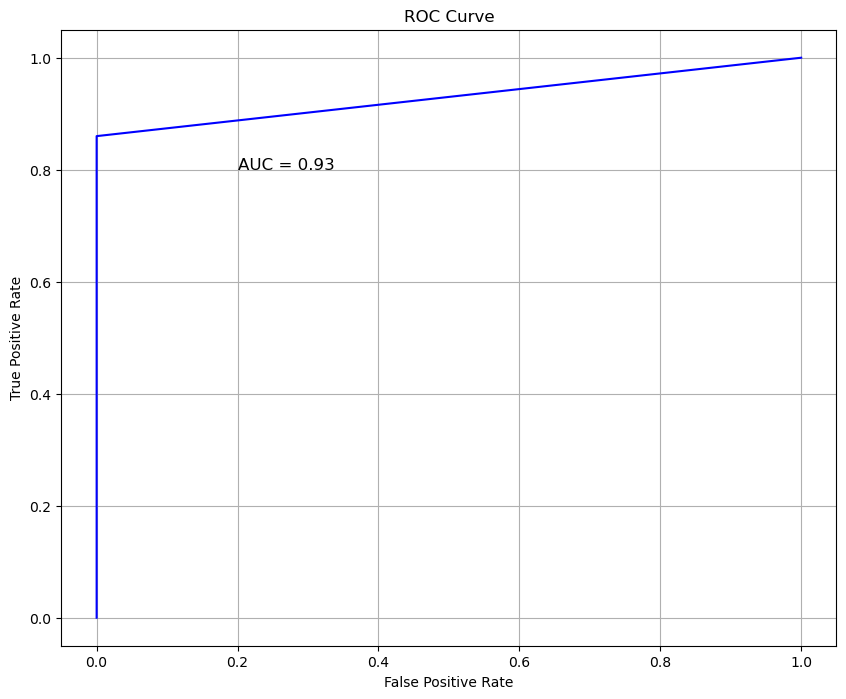

In [70]:
# ROC 
tco_knn_fpr, tco_knn_tpr, tco_knn_thresholds = roc_curve(tco_y_test, tco_knn_y_pred_prob)
tco_knn_auc = roc_auc_score(tco_y_test, tco_knn_y_pred_prob)
plt.plot(tco_knn_fpr, tco_knn_tpr, color='b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.text(0.2, 0.8, f'AUC = {tco_knn_auc:.2f}', fontsize=12)
plt.show()

In [108]:
precision = precision_score(tco_y_test, tco_knn_y_pred)
recall = recall_score(tco_y_test, tco_knn_y_pred)
f1 = f1_score(tco_y_test, tco_knn_y_pred)
accuracy = accuracy_score(tco_y_test, tco_knn_y_pred)
specificity = specificity_score(tco_y_test, tco_knn_y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Specificity:", specificity)

Precision: 1.0
Recall: 0.57
F1-Score: 0.7261146496815287
Accuracy: 0.914
Specificity: 1.0


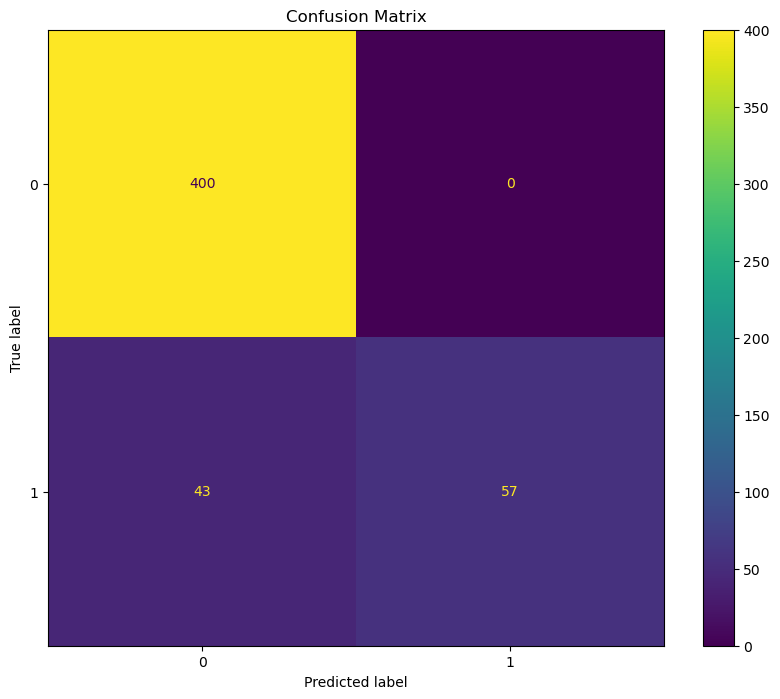

In [109]:
# Confusion Matrix
cm = confusion_matrix(tco_y_test, tco_knn_y_pred, labels=tco_knn.classes_)
plt.rcParams["figure.figsize"] = (10, 8)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tco_knn.classes_)
cm_plot.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curves All Models

In [73]:
# Bagging and Boosting Models
# ROC
tco_rf_fpr, tco_rf_tpr, tco_rf_thresholds = roc_curve(tco_y_test, boosting_models['tco_rf_y_pred_prob'])
tco_xgb_fpr, tco_xgb_tpr, tco_xgb_thresholds = roc_curve(tco_y_test, boosting_models['tco_xgb_y_pred_prob'])
tco_ada_fpr, tco_ada_tpr, tco_ada_thresholds = roc_curve(tco_y_test, boosting_models['tco_ada_y_pred_prob'])

# AUC 
tco_rf_auc = roc_auc_score(tco_y_test, boosting_models['tco_rf_y_pred_prob'])
tco_xgb_auc = roc_auc_score(tco_y_test, boosting_models['tco_xgb_y_pred_prob'])
tco_ada_auc = roc_auc_score(tco_y_test, boosting_models['tco_ada_y_pred_prob'])

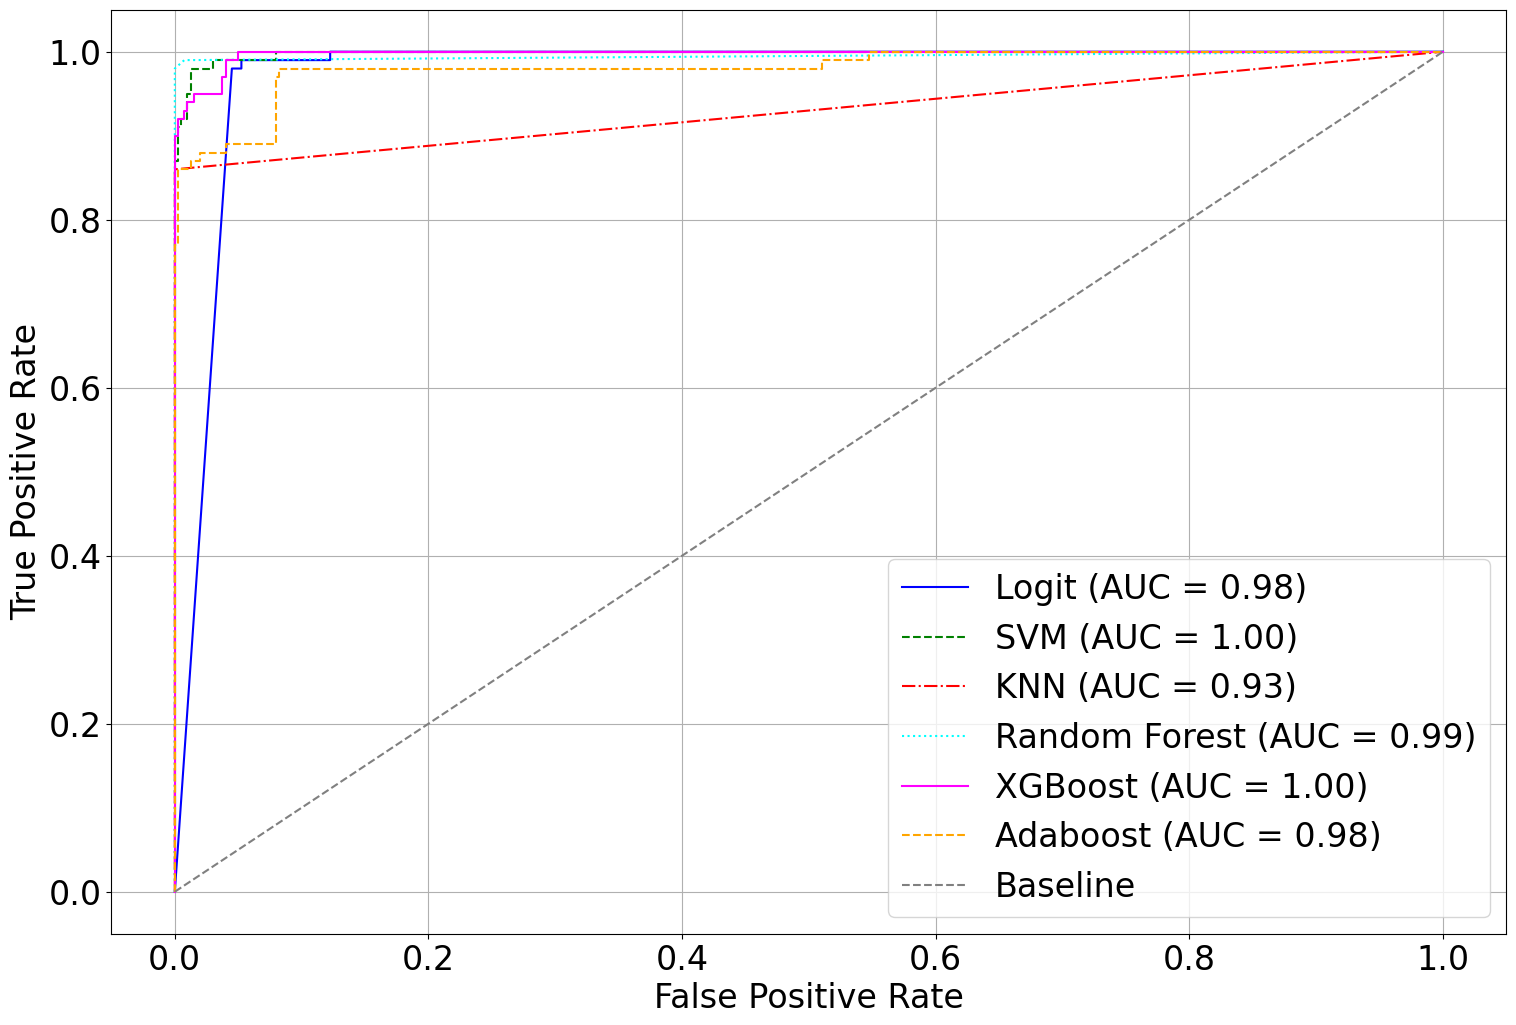

In [105]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']
line_styles = ['-', '--', '-.', ':', '-', '--']
models = ['Logit', 'SVM', 'KNN', 'Random Forest', 'XGBoost', 'Adaboost']
fpr_tpr_auc = [(tco_logit_fpr, tco_logit_tpr, tco_logit_auc), 
               (tco_svm_fpr, tco_svm_tpr, tco_svm_auc), 
               (tco_knn_fpr, tco_knn_tpr, tco_knn_auc), 
               (tco_rf_fpr, tco_rf_tpr, tco_rf_auc), 
               (tco_xgb_fpr, tco_xgb_tpr, tco_xgb_auc), 
               (tco_ada_fpr, tco_ada_tpr, tco_ada_auc)]

plt.figure(figsize=(18, 12))

for i, (fpr, tpr, auc) in enumerate(fpr_tpr_auc):
    plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[i], 
             label=f'{models[i]} (AUC = {auc:.2f})')

baseline = plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')[0]

plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)

plt.legend(loc='lower right', fontsize='x-large', title_fontsize='20', frameon=True,prop={'size': 24})


plt.show()